# 1. Introduction

#### Problem Statement

#### Motivation


#### Approach

#### Libraries

### Install Libraries

In [141]:
import os # This line is necessary to set the working directory for the script
os.chdir(r"C:\Users\Zaid.Qarout\Toxic Comment Classification Challenge")


In [142]:
pip install -r requirements.txt # Install the required packages from the requirements.txt file

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [143]:
!python -m spacy download en_core_web_sm # Download the small English model for spaCy
!python -m spacy download en_core_web_md # Download the medium English model for spaCy
!python -m textblob.download_corpora # Download the corpora for TextBlob

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Zaid.Qarout\AppData\Roaming\nltk_data...
[nltk_

## Importing Libraries and Defining Variables

In [144]:
import numpy as np
import pandas as pd
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

from collections import Counter
from spacy import displacy
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, hamming_loss
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud
from scipy.sparse import hstack, csr_matrix
from sklearn.utils.class_weight import compute_sample_weight
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier


# 2. Load Data

In [145]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'

df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

#### Observe the first 5 rows of the data set

In [146]:
df_train.head() # Display the first few rows of the training data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Check the shape of the dataset

In [147]:
print('Train shape', df_train.shape)

Train shape (159571, 8)


#### Check the column names

In [148]:
df_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

#### Check for missing data

In [149]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### View label distribution
Sort values to see the most common labels first

In [150]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train[labels].sum().sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

# 3. Preprocessing and Data Cleaning

### Check data balance

C:\Users\Zaid.Qarout\AppData\Local\Temp\ipykernel_31648\1226741191.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=label, ax=axes[i], palette='coolwarm')
C:\Users\Zaid.Qarout\AppData\Local\Temp\ipykernel_31648\1226741191.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=label, ax=axes[i], palette='coolwarm')
C:\Users\Zaid.Qarout\AppData\Local\Temp\ipykernel_31648\1226741191.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x=label, ax=axes[i], palette='coolwarm')
C:\Users\Zaid.Qa

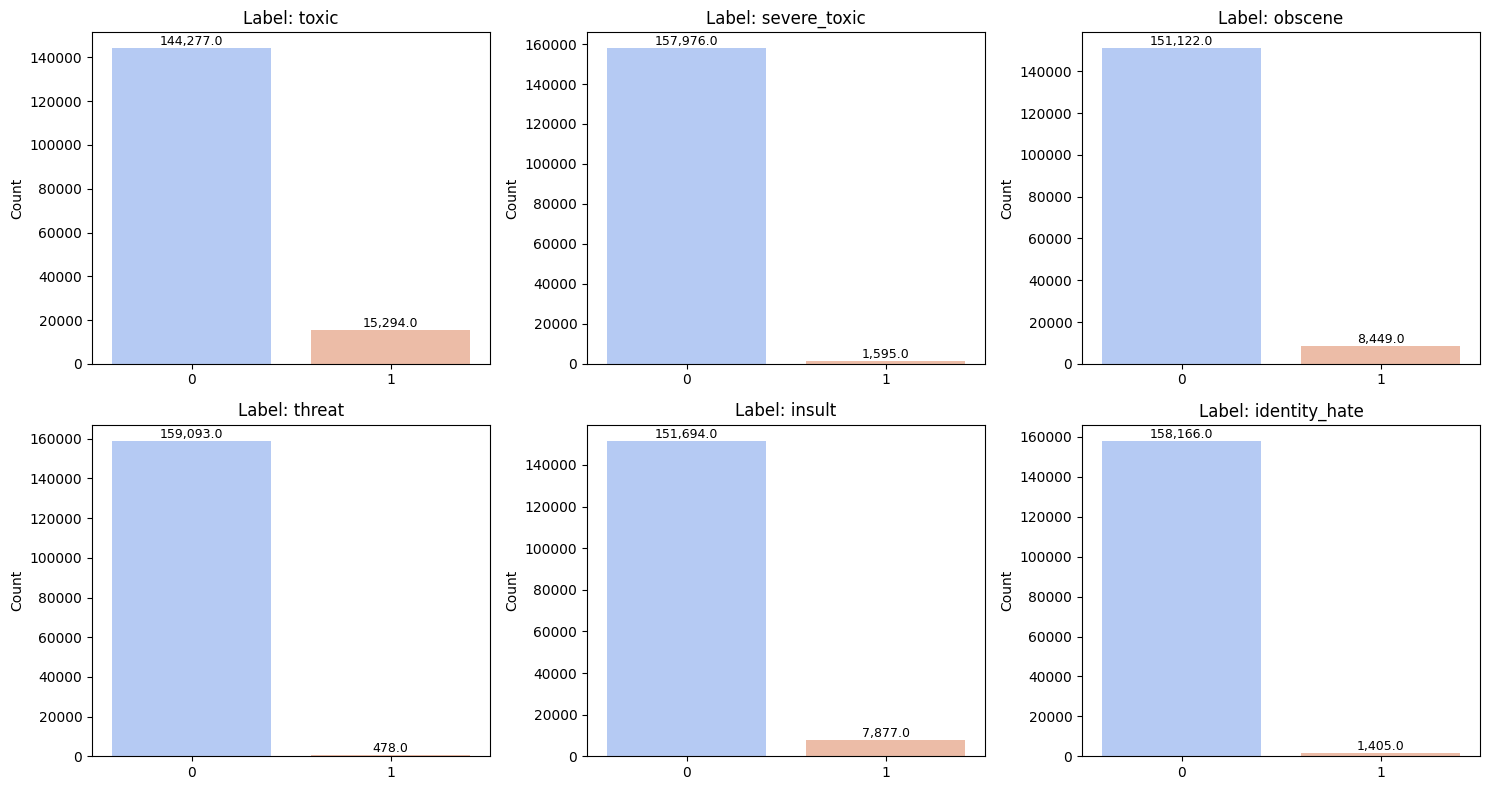

In [151]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Plot count of each label
for i, label in enumerate(labels):
    sns.countplot(data=df_train, x=label, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Label: {label}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

    # Annotate the bars with counts
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{height:,}', (p.get_x() + p.get_width()/2., height),
                         ha='center', va='bottom', fontsize=9)

# Adjust layout
plt.tight_layout()
plt.show()


There is a clear imbalance of data which can cause the majority class to be predicted more than the others. The score is deceptively high in accuracy but low in recall or F1-score for the rare class and struggle with ROC/AUC or confusion matrix interpretation since the false negatives are the majority. Therefore, this will be considered later on when training the models. For example, adding `class_weight='balanced'` to logistic regression will tell the model to penalise mistakes on minority classes more which balances the loss function.

### Variables

In [152]:
# fast, vector-ready model (has 300-d GloVe vectors)
nlp = spacy.load("en_core_web_md", disable=["parser"]) # Load the spaCy model with only the tokeniser, disabling the parser for speed

if "sentencizer" not in nlp.pipe_names: # Check if the sentencizer is already in the pipeline
    nlp.add_pipe("sentencizer")

### Clean the data

In [153]:
def clean(text):
    """Function to clean the text data using spaCy.
    Args:
        text (str): The input text to be cleaned.
    Returns: the cleaned text as a string."""
    PUNCTUATION_TABLE = str.maketrans("", "", string.punctuation.replace("'", ""))  # Remove punctuation except apostrophes
    return text.lower().translate(PUNCTUATION_TABLE).replace('\n', ' ').replace('\r', ' ').strip()

### Tokenise the data

In [154]:
# Define regex patterns for token filtering
url_pattern = re.compile(r'https?://\S+|www\.\S+')
email_pattern = re.compile(r'\b[\w\.-]+?@\w+?\.\w+?\b') # e.g., someone@email.com
repetition_pattern = re.compile(r'(.)\1{3,}')  # e.g., 'aaaa', 'bbbb'
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE
)

def normalise_text(text):
    # Replace accents/diacritics with base letters (e.g., ç → c, ü → u)
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') 

def tokenise(doc):
    """Function to tokenise the text data using spaCy.
    Args:
        doc (str): The text to be tokenised.
    Returns: a list of tokens (lemmas) as strings."""
    # Tokenise the document using spaCy
    tokens = []
    for token in doc: # Iterate through each token in the document
        lemma = token.lemma_.lower() # Convert lemma to lowercase
        norm = normalise_text(lemma).strip()  # Normalise and strip whitespace

        # Skip empty tokens or tokens that are not alphanumeric
        if not norm or not norm.isalnum():
            continue

        # Re-check stop words after lemmatisation
        if nlp.vocab[norm].is_stop:
            continue

        if (
            not token.is_punct and  # Exclude punctuation
            not token.is_space and  # Exclude spaces
            len(norm.strip()) > 1 and # Exclude single-character tokens (e.g., 'a', 'I' etc. except for contractions like "don't", "can't" etc. which are handled by the tokenisation process)
            not url_pattern.match(norm) and # Exclude tokens that match the URL pattern
            not email_pattern.match(norm) and  # Exclude tokens that match the email pattern
            not repetition_pattern.match(norm) and # Exclude tokens that match the repetition pattern (e.g., 'aaaa', 'bbbb' etc.)
            not emoji_pattern.match(norm) and # Exclude tokens that match the emoji pattern (e.g., '😊', '😂' etc.)
            not re.match(r'^\d+$', norm) and # Exclude tokens that are purely numeric (e.g., '123', '4567' etc. but keep numbers in words like "one", "two" etc. which are handled by the tokenisation process)
            not re.match(r"^\d{1,3}(\.\d{1,3}){3}$", norm) and # Exclude tokens that are IP addresses (e.g., 62.158.73.165)'
            token.ent_type_ not in {'PERSON', 'ORG', 'GPE'} # Exclude named entities like persons, organisations, and geopolitical entities
        ):
            tokens.append(norm) # Append the normalised token to the list


    return tokens # Return the list of tokens

### Get sentiment scores

In [155]:
# def get_sentiment_scores(text):
#     """
#     Function to get the sentiment scores of the text data.
#     Args:
#         text (str): The text to be processed.
#     Returns: a dictionary with polarity and subjectivity scores."""
#     blob = TextBlob(text)  # Create a TextBlob object
#     return {'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity}  # Return the sentiment scores as a dictionary

# 4. Feature engineering

In [156]:
# Extract features for training/EDA (full) or fast inference (minimal for test)
def extract_features(text, is_train=True, nlp_model=nlp):
    """Extract features for training/EDA (full) or fast inference (minimal for test).
    
    Args:
        text (str): The input comment.
        is_train (bool): True = full feature set (for EDA + training), False = minimal (for test/Kaggle submission).
        nlp_model (spacy.lang): The spaCy NLP model to use for processing the text.
        
    Returns:
        dict: Extracted features.
    """

    # Check if the NLP model is provided and raise an error if not
    if nlp_model is None: 
            raise ValueError("You must provide an NLP model via `nlp_model`.")
    
    # Handle empty or invalid input
    if not isinstance(text, str) or not text.strip():
        return {
            'cleaned_text': '', # Return empty cleaned text for invalid input
            'tokens': [], # Return empty tokens for invalid input
        }

    doc = nlp_model(text)  # full pipeline (parser/tagger must be enabled)

    # Base features that are always needed
    base = {
        'cleaned_text': clean(text), # Clean the text using the clean function
        'tokens': tokenise(doc), # Tokenise the document using the tokenise function
    }

    # Extra features only needed for training / EDA / visualizations
    if is_train: # Check if the features are for training
        base.update({
            'pos_tags': [(token.text, token.pos_) for token in doc], # Extract part-of-speech tags as a list of tuples (text, pos)
            'ner': [(ent.text, ent.label_) for ent in doc.ents], # Extract named entities as a list of tuples (text, label)
        })

    return base # Return the extracted features as a dictionary


### Apply data cleaning methods

In [157]:
# ============ DEVELOPMENT MODE =========== #
# (a small sample to save time)

# df_small = df_train.sample(n=5000, random_state=42)
# features = df_small['comment_text'].apply(extract_features)
# features_df = pd.json_normalize(features, sep='_')

# df_small = df_small.reset_index(drop=True)
# features_df = features_df.reset_index(drop=True)

# df = pd.concat([df_small, features_df], axis=1)
# ========================================= #

# ============ FULL DATASET MODE (SUBMISSION) =========== #
if os.path.exists("processed_full_dataset.pkl"):
    print("Loading preprocessed data...")
    df = pd.read_pickle("processed_full_dataset.pkl")
else:
    print("Running preprocessing pipeline...")
    features = df_train['comment_text'].apply(extract_features)
    features_df = pd.json_normalize(features, sep='_')

    df_train = df_train.reset_index(drop=True)
    features_df = features_df.reset_index(drop=True)

    df = pd.concat([df_train, features_df], axis=1)

    # Save for future runs
    df.to_pickle("processed_full_dataset.pkl")
    print("Saved preprocessed data to `processed_full_dataset.pkl`")
# ======================================================== #


Loading preprocessed data...


In [158]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,tokens,pos_tags,ner,sentiment_scores_polarity,sentiment_scores_subjectivity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, edit, username, hardcore, metall...","[(Explanation, NOUN), (\n, SPACE), (Why, SCONJ...","[(New York Dolls, GPE), (FAC, ORG), (now.89.20...",0.136364,0.454545
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww he matches this background colour i'm se...,"[match, background, colour, seemingly, stick, ...","[(D'aww, PROPN), (!, PUNCT), (He, PRON), (matc...","[(21:51, January 11, DATE), (2016, DATE), (UTC...",0.287500,0.550000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...,"[hey, man, try, edit, war, guy, constantly, re...","[(Hey, INTJ), (man, NOUN), (,, PUNCT), (I, PRO...",[],0.160000,0.406667
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,"[real, suggestion, improvement, wonder, sectio...","[("", PUNCT), (\n, SPACE), (More, ADJ), (\n, SP...","[(first, ORDINAL), (Wikipedia, PERSON)]",0.200000,0.301042
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]","[(You, PRON), (,, PUNCT), (sir, PROPN), (,, PU...",[],0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,and for the second time of asking when your vi...,"[second, time, asking, view, completely, contr...","[("", PUNCT), (:, PUNCT), (:, PUNCT), (:, PUNCT...","[(second, ORDINAL)]",0.228571,0.557143
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,you should be ashamed of yourself that is a ...,"[ashamed, horrible, thing, talk, page]","[(You, PRON), (should, AUX), (be, AUX), (asham...","[(128.61.19.93, CARDINAL)]",-1.000000,1.000000
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,spitzer umm theres no actual article for pro...,"[umm, actual, article, prostitution, ring, cru...","[(Spitzer, PROPN), (\n\n, SPACE), (Umm, PROPN)...","[(Spitzer, ORG)]",0.000000,0.100000
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,and it looks like it was actually you who put ...,"[look, like, actually, speedy, version, delete...","[(And, CCONJ), (it, PRON), (looks, VERB), (lik...","[(first, ORDINAL)]",0.125000,0.216667


# 6. Text vectorisation (TF-IDF and WordEmbeddings)

### TF-IDF (Term Frequency - Inverse Document Frequency)

Generate TF-IDF features from the text data and sentiment scores for training and validation sets

In [159]:
print("Generating TF-IDF features from scratch...")

# Prepare the text and labels
X_text_tfidf = df['tokens'].apply(lambda tokens: " ".join(tokens))
y_tfidf = df[labels]

# Train-test split
X_train_text_tfidf, X_val_text_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    X_text_tfidf, y_tfidf, test_size=0.2, random_state=42
)

# Word-level TF-IDF
word_vec = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    lowercase=False,
    min_df=1,
    max_df=0.9,
    max_features=30000
)
X_word_train = word_vec.fit_transform(X_train_text_tfidf)
X_word_val = word_vec.transform(X_val_text_tfidf)

# Char-level TF-IDF
char_vec = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    lowercase=False,
    min_df=1,
    max_df=0.9,
    max_features=10000
)
X_char_train = char_vec.fit_transform(X_train_text_tfidf)
X_char_val = char_vec.transform(X_val_text_tfidf)

# Combine word + char – no sentiment
X_combined_tfidf_train = hstack([X_word_train, X_char_train])
X_combined_tfidf_val = hstack([X_word_val, X_char_val])

Generating TF-IDF features from scratch...


# 7. Model training and evaluation

In [160]:
# Define a list to store model training results
results = []

# Define a dictionary to store AUC scores
auc_scores = {}

In [161]:
def get_probabilities(model, X):
    """ Extracts probability predictions for OneVsRestClassifier safely.
    Ensures shape is (n_samples, n_classes), even if only one class was seen.
    Args:
        model (OneVsRestClassifier): The trained model.
        X (np.ndarray or sparse matrix): Input features.
    Returns:
        np.ndarray: Probability predictions with shape (n_samples, n_classes).
    """
    probas = []
    for clf in model.estimators_:
        try:
            p = clf.predict_proba(X)
            if p.shape[1] == 2:
                probas.append(p[:, 1])  # positive class
            else:
                # Only one class present in training
                probas.append(np.zeros(X.shape[0]))
        except:
            probas.append(np.zeros(X.shape[0]))
    return np.array(probas).T  # shape: (n_samples, n_classes)


In [162]:
def evaluate_model(name, y_true, y_pred, y_proba=None, labels=None):
    """ Evaluate a multilabel classification model and print key metrics.
    Args:
        name (str): Name of the model for display and reporting.
        y_true (pd.DataFrame or np.ndarray): True binary labels (shape: [n_samples, n_classes]).
        y_pred (np.ndarray): Predicted binary labels (shape: [n_samples, n_classes]).
        y_proba (np.ndarray, optional): Predicted probabilities or scores (shape: [n_samples, n_classes]). Required for AUC computation.
        labels (list, optional): List of class label names for reporting.

    Returns:
        dict: Dictionary containing model name, accuracy, F1 scores, AUC scores, and classification report.
    """
    print(f"\nEvaluation for: {name}")
    print("-" * 60)

    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0) # Generate classification report

    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0)) # Print the classification report

    exact = accuracy_score(y_true, y_pred) # Exact accuracy
    hamming = 1 - hamming_loss(y_true, y_pred) # Hamming accuracy

    if y_proba is not None: # Check if probabilities are provided
        auc_per_class, macro_auc, micro_auc = evaluate_auc(y_true.values, y_proba, name, labels)
    else:
        auc_per_class, macro_auc, micro_auc = {}, 0.0, 0.0 # Handle case where no probabilities are provided
        print("AUC skipped (no probabilities provided)")

    # Print summary
    print(f"Exact Match Accuracy: {exact:.4f}")
    print(f"Hamming Accuracy: {hamming:.4f}")
    print(f"Micro AUC: {micro_auc:.4f}")
    print(f"Macro AUC: {macro_auc:.4f}")

    # Return a summary dictionary
    return {
        "Model": name,
        "Exact Match Accuracy": exact,
        "Hamming Accuracy": hamming,
        "Micro F1": report["micro avg"]["f1-score"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Micro AUC": micro_auc,
        "Macro AUC": macro_auc,
        "AUC per class": auc_per_class,
        "Classification Report": report
    }

In [163]:
def evaluate_auc(y_true, y_scores, model_name, labels):
    """ Function to evaluate AUC scores for each class and print the results.
    Args:
        y_true (np.ndarray): True labels in a binary format (shape: [n_samples, n_classes]).
        y_scores (np.ndarray): Predicted scores or probabilities (shape: [n_samples, n_classes]).
        model_name (str): Name of the model being evaluated.
        labels (list): List of class labels.
    Returns:
        auc_per_class (dict): A dictionary with AUC scores for each class.
        macro_auc (float): Macro-average AUC score.
        micro_auc (float): Micro-average AUC score.
    """
    
    # Compute AUC per class
    auc_per_class = {}
    for i, label in enumerate(labels):
        try:
            auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        except ValueError:
            auc = 0.0 # Handle case where only one class is present in y_true
        auc_per_class[label] = auc

    # Print AUC scores
    print(f"AUC Scores for: {model_name}")
    for label, auc in auc_per_class.items():
        print(f"  {label:<15}: {auc:.3f}")

    # Compute and print macro and micro averages
    macro_auc = roc_auc_score(y_true, y_scores, average='macro')
    micro_auc = roc_auc_score(y_true, y_scores, average='micro')

    print(f"\nMacro AUC: {macro_auc:.3f}") # Print macro-average AUC
    print(f"Micro AUC: {micro_auc:.3f}") # Print micro-average AUC
    
    return auc_per_class, macro_auc, micro_auc

## Logistic regression

In [164]:
# For TF-IDF

# Define and train the model using TF-IDF features
model_lg_tfidf = OneVsRestClassifier(
    LogisticRegression(C=4, max_iter=1000, class_weight='balanced', random_state=42)
)
model_lg_tfidf.fit(X_combined_tfidf_train, y_train_tfidf)

y_pred_lg_tfidf = model_lg_tfidf.predict(X_combined_tfidf_val) # Make predictions on validation set
y_scores_lg_tfidf = get_probabilities(model_lg_tfidf, X_combined_tfidf_val) # Get probabilities for AUC computation

print("TF-IDF + Logistic Regression")

# Evaluate the model on the validation set
model_evaluation_tfidf_lg = evaluate_model(
    name="TF-IDF + Logistic Regression",
    y_true=y_val_tfidf,
    y_pred=y_pred_lg_tfidf,
    y_proba=y_scores_lg_tfidf,
    labels=labels
)

auc_scores["TF-IDF + LG"] = model_evaluation_tfidf_lg
results.append(model_evaluation_tfidf_lg)

TF-IDF + Logistic Regression

Evaluation for: TF-IDF + Logistic Regression
------------------------------------------------------------
               precision    recall  f1-score   support

        toxic       0.64      0.85      0.73      3056
 severe_toxic       0.28      0.80      0.41       321
      obscene       0.68      0.88      0.77      1715
       threat       0.18      0.68      0.28        74
       insult       0.54      0.85      0.66      1614
identity_hate       0.26      0.67      0.37       294

    micro avg       0.55      0.85      0.67      7074
    macro avg       0.43      0.79      0.54      7074
 weighted avg       0.59      0.85      0.69      7074
  samples avg       0.06      0.08      0.07      7074

AUC Scores for: TF-IDF + Logistic Regression
  toxic          : 0.967
  severe_toxic   : 0.977
  obscene        : 0.983
  threat         : 0.983
  insult         : 0.972
  identity_hate  : 0.966

Macro AUC: 0.975
Micro AUC: 0.981
Exact Match Accuracy: 0.87

# 8. Results visualisation

In [165]:
# Print all results
for res in results:
    print(res["Model"])

 # Create a dictionary keyed by model name (keeps last occurrence to remove any duplicates)
unique_results = {res["Model"]: res for res in results}
results = list(unique_results.values())

TF-IDF + Logistic Regression


Given the multilabel nature of the task, I have evaluated models using both micro and macro averages for Precision, Recall, F1-score, and AUC. Micro metrics emphasize overall performance, while macro metrics highlight how well the model performs across less frequent classes.

In [166]:
# Convert results to DataFrame for better display

# Add precision and recall to each result using the stored classification report
for res in results:
    report = res["Classification Report"]
    res["Micro Precision"] = report["micro avg"]["precision"]
    res["Macro Precision"] = report["macro avg"]["precision"]
    res["Micro Recall"] = report["micro avg"]["recall"]
    res["Macro Recall"] = report["macro avg"]["recall"]

# Define which columns to display
RESULT_METRICS = [
    "Model",
    "Exact Match Accuracy",
    "Hamming Accuracy",
    "Micro Precision", "Macro Precision",
    "Micro Recall", "Macro Recall",
    "Micro F1", "Macro F1",
    "Micro AUC", "Macro AUC"
]


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show main metrics
display(results_df[RESULT_METRICS])

,Model,Exact Match Accuracy,Hamming Accuracy,Micro Precision,Macro Precision,Micro Recall,Macro Recall,Micro F1,Macro F1,Micro AUC,Macro AUC
0,TF-IDF + Logistic Regression,0.874103,0.969215,0.554629,0.428422,0.846056,0.78755,0.670025,0.53694,0.980524,0.974775


## Visual comparator for top performing model

In [168]:
def plot_auc_scores(auc_scores, class_labels):
    """ Plot AUC scores for each class per model using a grouped bar chart.
    
    Args:
        auc_scores (dict): AUC score dict with model names as keys and class AUCs inside.
        class_labels (list): List of class names (e.g., ["toxic", "obscene", ...])
    
    Returns: None
    """
    # Build a DataFrame with models as rows and class labels as columns
    data = {
        model: [score_dict["AUC per class"][cls] for cls in class_labels]
        for model, score_dict in auc_scores.items()
    }

    df = pd.DataFrame(data, index=class_labels)

    # Plot
    ax = df.T.plot(kind="bar", figsize=(12, 6))
    ax.set_title("AUC Scores per Class")
    ax.set_ylabel("AUC Score")
    ax.set_xlabel("Model")
    ax.set_ylim(0.0, 1.05)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_grouped_auc_scores(auc_scores, class_labels):
    """
    Plots grouped bar chart of AUC scores for each class and model.

    Args:
        auc_scores (dict): Dictionary of model names to AUC values.
        class_labels (list): List of class names to plot.

    Returns: None
    """
    models = list(auc_scores.keys())
    n_classes = len(class_labels)
    n_models = len(models)
    bar_width = 0.12

    x = np.arange(n_classes) # positions for classes

    plt.figure(figsize=(14, 6))

    for i, model in enumerate(models): # Plot AUC scores for each class and model separately
        scores = [auc_scores[model]["AUC per class"][cls] for cls in class_labels]
        plt.bar(x + i * bar_width, scores, width=bar_width, label=model)

    plt.xticks(x + (n_models / 2 - 0.5) * bar_width, class_labels, rotation=45)
    plt.ylabel("AUC Score")
    plt.title("AUC Scores by Class and Model")
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_macro_micro_auc(auc_scores):
    """ Function to plot Macro and Micro AUC scores for each model.
    Args:
        auc_scores (dict): A dictionary with AUC scores for each model.
    
    Returns: None
    """
    df = pd.DataFrame([
        {"Model": model, "Macro AUC": scores["Macro AUC"], "Micro AUC": scores["Micro AUC"]}
        for model, scores in auc_scores.items()
    ]) # Create DataFrame with model names and AUC scores
    
    df.set_index("Model").plot(kind='bar', figsize=(8, 5))
    plt.title("Macro vs Micro AUC")
    plt.ylabel("AUC Score")
    plt.xticks(rotation=45)
    plt.ylim(0.0, 1.05)
    plt.tight_layout()
    plt.show()

## Other visuals

In [170]:
# Visualisation helpers
def bar_true_vs_pred(y_true: pd.DataFrame,
                     y_pred: np.ndarray,
                     labels: list,
                     title_suffix: str = ""):
    """ Plot true vs. predicted counts for each class.

    Args: 
        y_true (pd.DataFrame): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (list): List of label names.
        title_suffix (str, optional): Additional suffix for the title. Defaults to "".
    
    Returns: None, but displays a bar plot of the true vs. predicted counts for each class.
    """
    true_counts = y_true.values.sum(axis=0)
    pred_counts = y_pred.sum(axis=0)

    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x - .2, true_counts,  width=.4, label="True", color="steelblue")
    plt.bar(x + .2, pred_counts, width=.4, label="Pred", color="tomato")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Samples")
    plt.title(f"True vs. Predicted counts {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def per_label_confusion_matrices(y_true: pd.DataFrame,
                                 y_pred: np.ndarray,
                                 labels: list,
                                 cmap="YlOrRd"): # YellowOrangeRed color map for confusion matrices.
    """ Create confusion matrices for each label.
    
    Args:
        y_true (pd.DataFrame): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (list): List of label names.
        cmap (str, optional): Color map for the heatmap. Defaults to "YlOrRd".
        
    Returns: None, but displays confusion matrices for each label.
    """
    n = len(labels)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 4*nrows),
                             squeeze=False)
    for idx, lab in enumerate(labels):
        r, c = divmod(idx, ncols)
        cm = confusion_matrix(y_true[lab], y_pred[:, idx])
        sns.heatmap(cm,
                    annot=True, fmt="d",
                    cbar=False, cmap=cmap,
                    ax=axes[r, c])
        axes[r, c].set_title(lab)
        axes[r, c].set_xlabel("Predicted")
        axes[r, c].set_ylabel("True")
    # turn off empty plots
    for j in range(idx+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")
    plt.tight_layout()
    plt.show()


def per_label_roc_curves(y_true: pd.DataFrame,
                         y_prob: np.ndarray,
                         labels: list):
    """ Draw ROC curve for every label (works if you have probability scores).
    
    Args:
        y_true (pd.DataFrame): True labels.
        y_prob (np.ndarray): Predicted labels.
        labels (list): List of label names.

    Returns: None, but displays ROC curves for each label.
    """
    plt.figure(figsize=(6, 6))
    for i, lab in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_true[lab], y_prob[:, i])
        auc  = roc_auc_score(y_true[lab], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{lab} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="grey")
    plt.xlabel("False-positive rate")
    plt.ylabel("True-positive rate")
    plt.title("ROC curves (per label)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def classification_table(y_true: pd.DataFrame,
                         y_pred: np.ndarray,
                         labels: list):
    """ Create a classification report table and display it.
    Args:
        y_true (pd.DataFrame): True labels in a binary format.
        y_pred (np.ndarray): Predicted binary labels.
        labels (list): List of class names.
    Returns:
        pd.DataFrame: DataFrame with classification report metrics.
    """
    report = classification_report(y_true.values,
                                   y_pred,
                                   target_names=labels,
                                   output_dict=True,
                                   zero_division=0)
    df = (pd.DataFrame(report).T
            .drop(["accuracy", "macro avg", "weighted avg",
                   "micro avg", "samples avg"],
                  errors="ignore"))            # <-- key change
    display(df.style.format("{:.3f}")
                  .background_gradient(cmap="Blues"))
    return df


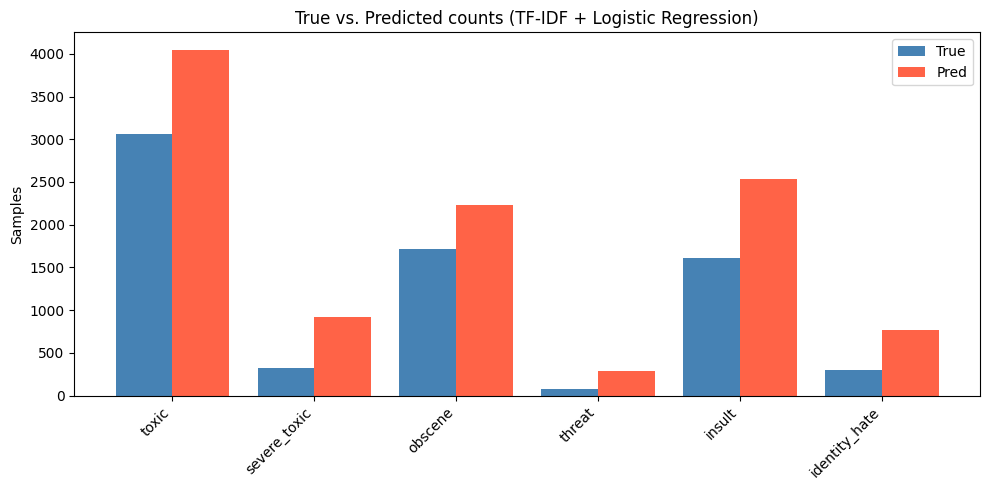

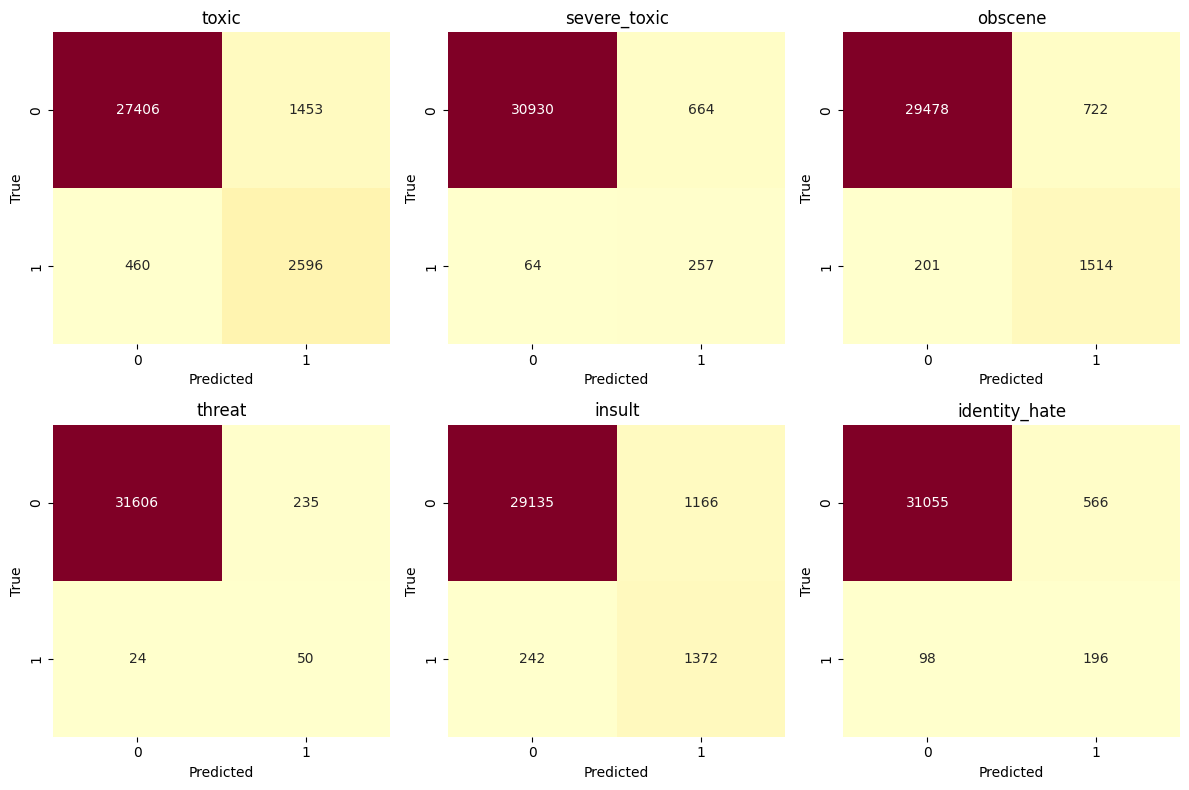

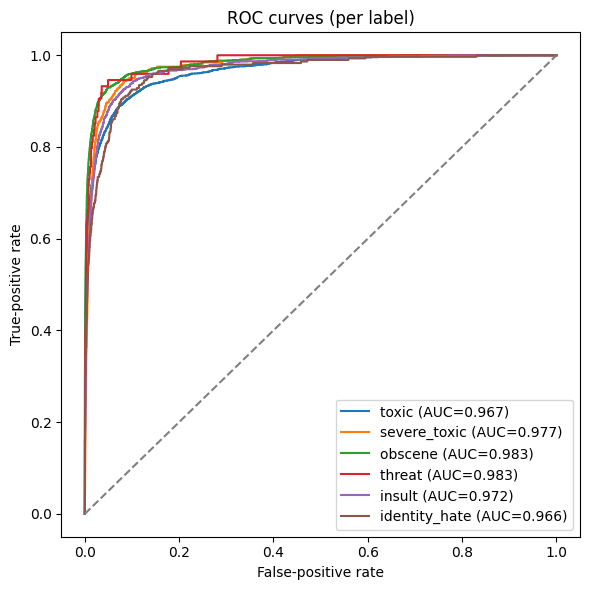

,precision,recall,f1-score,support
toxic,0.641,0.849,0.731,3056.000
severe_toxic,0.279,0.801,0.414,321.000
obscene,0.677,0.883,0.766,1715.000
threat,0.175,0.676,0.279,74.000
insult,0.541,0.850,0.661,1614.000
identity_hate,0.257,0.667,0.371,294.000


,precision,recall,f1-score,support
toxic,0.641146,0.849476,0.730753,3056.0
severe_toxic,0.279045,0.800623,0.413849,321.0
obscene,0.677102,0.882799,0.766388,1715.0
threat,0.175439,0.675676,0.278552,74.0
insult,0.540583,0.850062,0.660886,1614.0
identity_hate,0.257218,0.666667,0.371212,294.0


In [171]:
y_true_lg_tfidf = y_val_tfidf
y_pred_lg_tfidf = model_lg_tfidf.predict(X_combined_tfidf_val)
y_prob_lg_tfidf = model_lg_tfidf.predict_proba(X_combined_tfidf_val)

bar_true_vs_pred(y_true_lg_tfidf, y_pred_lg_tfidf, labels, "(TF-IDF + Logistic Regression)")
per_label_confusion_matrices(y_true_lg_tfidf, y_pred_lg_tfidf, labels)
per_label_roc_curves(y_true_lg_tfidf, y_prob_lg_tfidf, labels)
classification_table(y_true_lg_tfidf, y_pred_lg_tfidf, labels)

The per-label confusion matrices provide a clear breakdown of the classifier's strengths and weaknesses across each class. While the model performs well on more common labels like toxic, obscene, and insult, showing a good balance between precision and recall, it struggles significantly with rare classes such as severe_toxic and threat, often failing to identify any true positives. This highlights a common issue in multilabel classification: imbalanced label distribution can lead to poor recall for underrepresented classes. Overall, the matrices reinforce earlier AUC and F1 findings, offering valuable insight into where the model is reliable and where further tuning or data augmentation may be needed.

# 9. Create Kaggle submission file

In [172]:
TEST_FEATURES_PATH = "processed_test_features.pkl"

nlp_test = spacy.load("en_core_web_md", disable=["parser", "ner", "tagger"])
nlp_test.add_pipe("sentencizer")

if os.path.exists(TEST_FEATURES_PATH):
    print("Loaded cached test features.")
    df_test_processed = pd.read_pickle(TEST_FEATURES_PATH)
else:
    print("Processing and extracting features from test.csv ...")

    features_test = df_test['comment_text'].apply(extract_features, is_train=False, nlp_model=nlp_test)
    features_test_df = pd.json_normalize(features_test, sep='_')

    df_test = df_test.reset_index(drop=True)
    features_test_df = features_test_df.reset_index(drop=True)

    df_test_processed = pd.concat([df_test, features_test_df], axis=1)

    # Save for future use
    df_test_processed.to_pickle(TEST_FEATURES_PATH)
    print(f"Saved test features to {TEST_FEATURES_PATH}")

Loaded cached test features.


In [173]:
# TF-IDF + Sentiment
X_test_tokens = df_test_processed['tokens'].apply(lambda tokens: " ".join(tokens)) # Join tokens to form sentences
X_test_tfidf = tfidf_vec.transform(X_test_tokens) # Transform tokens to TF-IDF vectors

X_test_combined_tfidf = X_test_tfidf  # Only n-grams, no sentiment

In [174]:
final_model = model_lg_tfidf  # Logistic Regression with TF-IDF

# Predict probabilities
y_test_proba = get_probabilities(final_model, X_test_combined_tfidf)  # shape: (n_samples, 6)

# Create submission DataFrame
submission = pd.DataFrame(y_test_proba, columns=labels)
submission.insert(0, 'id', df_test['id'])  # Insert ID as the first column

# Save to CSV for Kaggle
submission.to_csv("submission.csv", index=False)
print("Submission saved to 'submission.csv'")


Submission saved to 'submission.csv'


Debugging is below

In [176]:
example = ["you are a stupid idiot and everyone hates you"]
example_tokens = [" ".join([t.lemma_.lower() for t in nlp_test(example[0]) if not t.is_stop and not t.is_punct])]
X_example_tfidf = tfidf_vec.transform(example_tokens)
X_example_sentiment = csr_matrix([[0.5, 0.8]])  # dummy values
X_example_combined = hstack([X_example_tfidf, X_example_sentiment])

y_example_pred = final_model.predict_proba(X_example_tfidf)
print(y_example_pred)

[[0.05560767 0.00918549 0.01055785 0.00024396 0.02042866 0.0036702 ]]


In [177]:
print(y_test_proba[:5])

[[5.29857313e-02 1.13609357e-02 9.58963864e-03 3.30852788e-04
  1.66249024e-02 1.39102894e-02]
 [2.49180885e-01 9.91915745e-03 4.07630725e-02 5.31703707e-04
  1.27886111e-01 5.93052354e-03]
 [1.28465558e-01 1.10268841e-02 9.28009428e-03 2.85848393e-04
  3.49778906e-02 4.53984008e-03]
 [6.90415822e-02 2.55717814e-03 1.39977816e-02 1.72208594e-04
  1.76065055e-02 2.84375476e-03]
 [7.58885944e-02 1.11742039e-02 2.82893816e-02 3.84303404e-04
  3.35166807e-02 9.49896113e-03]]


In [178]:
print(submission.head())
print(y_test_proba.mean(), y_test_proba.min(), y_test_proba.max())

                 id     toxic  severe_toxic   obscene    threat    insult  \
0  00001cee341fdb12  0.052986      0.011361  0.009590  0.000331  0.016625   
1  0000247867823ef7  0.249181      0.009919  0.040763  0.000532  0.127886   
2  00013b17ad220c46  0.128466      0.011027  0.009280  0.000286  0.034978   
3  00017563c3f7919a  0.069042      0.002557  0.013998  0.000172  0.017607   
4  00017695ad8997eb  0.075889      0.011174  0.028289  0.000384  0.033517   

   identity_hate  
0       0.013910  
1       0.005931  
2       0.004540  
3       0.002844  
4       0.009499  
0.040608715880191604 1.4446581191258112e-06 0.9975913804676222
